In [15]:
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import data

In [275]:
coaches = pd.read_json('coaches.json', encoding='utf-8')
players = pd.read_json('players.json', encoding='utf-8')
teams = pd.read_json('teams.json', encoding='utf-8')
matches_England = pd.read_json('matches_England.json', encoding='utf-8')
events_England = pd.read_json('events_England.json', encoding='utf-8')
# events_France = pd.read_json('events_France.json')
# events_Italy = pd.read_json('events_Italy.json')
# events_Germany = pd.read_json('events_Germany.json')

# RQ3: Which teams have the youngest coaches?

In [188]:
# Calculate age of all coaches.
coaches['age'] = coaches.birthDate.apply(lambda x: datetime.now().year - int(x[:4]) if x else 0)
coaches['age'] = coaches['age'].astype('int')

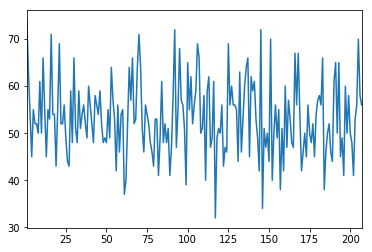

In [189]:
# Plot age distribution.
coaches['age'][coaches.age!=0].plot()

In [190]:
# Merge coaches and teams.
top10 = coaches[['age', 'currentTeamId']][(coaches.age!=0)&(coaches.currentTeamId!=0)].merge(teams[['wyId', 'name']], left_on='currentTeamId', right_on='wyId')

In [191]:
# During a season a team could have more coaches, in that case pick the younger of them.
top10 = pd.DataFrame(top10[['age','name']].groupby('name').min())

In [204]:
# Rank all the teams by the age of their coach and show the 10 teams with the youngest coaches. 
top10.sort_values(by='age').reset_index().loc[:9]

,name,age
0,Hoffenheim,32
1,Werder Bremen,37
2,Hamburger SV,38
3,Saint-\u00c9tienne,39
4,Sassuolo,40
5,Villarreal,41
6,Udinese,41
7,Milan,41
8,Mainz 05,41
9,Everton,42


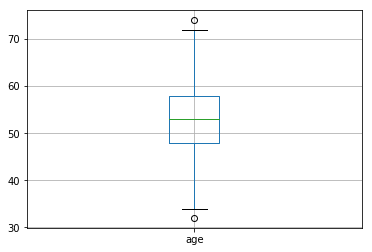

In [193]:
# Show the distirbutions of the ages of all coaches in Premier League, using a boxplot.
coaches[['age']][coaches.age!=0].boxplot()

# RQ4: Find the top 10 players with the highest ratio between completed passes and attempted passes.

In [167]:
# Build column pass_tags(only including 1801 and 1802)
def func(x):
    lst = [item['id'] for item in x if item['id'] in (1801, 1802)]
    return lst[0] if lst else None
events_England['pass_tags'] = events_England.tags.apply(lambda x: func(x))

In [168]:
# Build column count to count the number of passes
events_England['count'] = 1

In [169]:
# Calculate the total number of passes
df_count = pd.DataFrame(events_England[['eventSec', 'playerId', 'count']][events_England.eventName=='Pass'].groupby(['playerId']).sum()).reset_index()
df_count.rename(columns={'count':'total_count'}, inplace=True)

In [170]:
# Calculate the number of completed passes
df_1801 = pd.DataFrame(events_England[['playerId', 'count']][(events_England.eventName=='Pass')&(evente_England.pass_tags==1801)].groupby(['playerId']).sum()).reset_index()

In [199]:
# Calculate the ratio
top10_players = df_1801.merge(df_count, on='playerId')
top10_players['ratio'] = top10_players[['count', 'total_count']].apply(lambda x: x['count']/x['total_count'], axis=1)
top10_players.sort_values(by='ratio', ascending=False, inplace=True)

In [200]:
# Merge players to find the names of players
top10_players = top10_players[top10_players.eventSec>1e5].loc[:10,['playerId', 'ratio']]
top10_players = top10_players.merge(players[['wyId', 'firstName','lastName','middleName']], left_on='playerId', right_on='wyId')

In [203]:
top10_players[['firstName','lastName','middleName', 'ratio']].loc[:9]

,firstName,lastName,middleName,ratio
0,John,Stones,,0.975914
1,Gn\u00e9gn\u00e9ri Yaya,Tour\u00e9,,0.948020
2,Fabian,Delph,,0.945076
3,Vincent,Kompany,,0.943206
4,Andreas,Christensen,,0.940217
5,Per,Mertesacker,,0.939914
6,Phil,Jones,,0.938505
7,Nicol\u00e1s Hern\u00e1n,Otamendi,,0.937584
8,Mohamed Naser,Elsayed Elneny,,0.936451
9,\u0130lkay,G\u00fcndo\u011fan,,0.935556


# CRQ1: What are the time slots of the match with more goals?

In [276]:
# Build goal_tags to find all goals
def func(x):
    lst = [item['id'] for item in x if item['id'] in (101, 102)]
    return lst[0] if lst else None
events_England['goal_tags'] = events_England.tags.apply(lambda x: func(x))

In [277]:
# Note there is no extra time
events_England.matchPeriod.value_counts()

1H    323574
2H    319576
Name: matchPeriod, dtype: int64

In [279]:
# Calculate eventSet(plus 2H time)
goals = events_England[['eventSec', 'matchId', 'teamId', 'playerId', 'matchPeriod']][events_England.goal_tags.notnull()]
goals['eventSec'][goals.matchPeriod == '2H'] = goals['eventSec'][goals.matchPeriod == '2H'].apply(lambda x: x+45*60)
goals.sort_values('eventSec', inplace=True)

In [281]:
# Build 10 columns to define which time slot the goal belongs to
for i in range(10):
    goals['time_slot_%s'%i] = goals['eventSec'].apply(lambda x: 1 if 9*i <= x/60 < 9*(i+1) else 0)

## Make a barplot with the absolute frequency of goals in all the time slots.

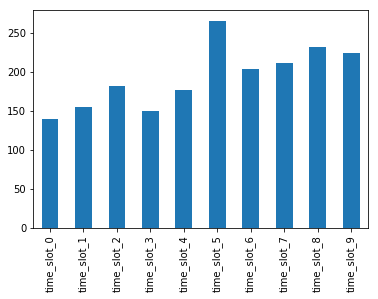

In [292]:
cols = ['time_slot_%s'%i for i in range(10)]
goals[cols].sum().plot.bar()

## Find the top 10 teams that score the most in the interval "81-90".

In [305]:
top10_teams = pd.DataFrame(goals[['teamId', 'time_slot_9']].groupby('teamId').sum()).reset_index()
top10_teams.sort_values('time_slot_9', ascending=False, inplace=True)
top10_teams = top10_teams.merge(teams[['wyId', 'name']], left_on='teamId', right_on='wyId')

In [309]:
top10_teams[['name', 'time_slot_9']].loc[:9]

,name,time_slot_9
0,Arsenal,16
1,Watford,16
2,Manchester City,15
3,West Ham United,15
4,Chelsea,14
5,Crystal Palace,13
6,Everton,12
7,Brighton & Hove Albion,12
8,Swansea City,12
9,Liverpool,11


In [314]:
cols.append('playerId')

In [320]:
good_players = pd.DataFrame(goals[cols].groupby('playerId').max()).reset_index()

In [329]:
good_players = good_players[(good_players.time_slot_0==1)&(good_players.time_slot_1==1)&(good_players.time_slot_2==1)&(good_players.time_slot_3==1)&(good_players.time_slot_4==1)&(good_players.time_slot_5==1)&(good_players.time_slot_6==1)&(good_players.time_slot_7==1)&(good_players.time_slot_8==1)&(good_players.time_slot_9==1)]

In [332]:
good_players = good_players.merge(players[['wyId', 'firstName','lastName','middleName']], left_on='playerId', right_on='wyId')

In [333]:
good_players[['firstName','lastName','middleName']]

,firstName,lastName,middleName
0,Adri\u00e1n,San Miguel del Castillo,
1,\u0141ukasz,Fabia\u0144ski,
2,Petr,\u010cech,
3,David,de Gea Quintana,
4,Jack,Butland,
5,Heurelho,da Silva Gomes,
6,Joe,Hart,
7,Ben,Foster,
8,Juli\u00e1n,Speroni,
9,Wayne,Hennessey,
